# Model training

This notebook provides high level overview of training a neural network classifier to predict leaf's condition.

Training parameters and image transformations are specified. Training the model is called, the results are obtained and plotted.

Begin with mounting a drive and making sure the files are in place.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = '/content/gdrive/My Drive/Colab Notebooks/Plant Pathology/data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd '/content/gdrive/My Drive/Colab Notebooks/Plant Pathology'

/content/gdrive/My Drive/Colab Notebooks/Plant Pathology


In [3]:
ls

 data/        model.py                            tools.py
 dataset.py  'Plant pathology - training.ipynb'  'Training CV.ipynb'
 loss.py      __pycache__/                        train.py
 main.py      submissions/


In [4]:
from tools import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataset import PlantDataset
from torch.utils.data import DataLoader
import cv2
import numpy as np
from train import *

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Training parameters, image transformations

In [0]:
# Define training parameters
# Size of input image
SIZE = 512

N_FOLDS = 5
N_EPOCHS = 10
BATCH_SIZE = 64

# Transforms
transforms_train = A.Compose([
    A.RandomResizedCrop(height=SIZE, width=SIZE, p=1.0),
    A.Flip(),
    A.ShiftScaleRotate(rotate_limit=1.0, p=0.8),

    # Pixels
    A.OneOf([
        A.IAAEmboss(p=1.0),
        A.IAASharpen(p=1.0),
        A.Blur(p=1.0),
    ], p=0.5),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=1.0),
        A.IAAPiecewiseAffine(p=1.0)
    ], p=0.5),

    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

transforms_valid = A.Compose([
    A.Resize(height=SIZE, width=SIZE, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

# Training

In [6]:
model, results = training_loop_single(N_EPOCHS=N_EPOCHS, BATCH_SIZE=BATCH_SIZE,
                                      transforms_train=transforms_train, transforms_valid=transforms_valid,
                                      data_dir=data_dir)

Epoch: 1 / 10
Epoch: 2 / 10
Epoch: 3 / 10
Epoch: 4 / 10
Epoch: 5 / 10
Epoch: 6 / 10
Epoch: 7 / 10
Epoch: 8 / 10
Epoch: 9 / 10
Epoch: 10 / 10
Validation score: 0.9782064574462743


# Inference

In [7]:
submission_df = pd.read_csv(data_dir + 'sample_submission.csv')
submission_df.iloc[:, 1:] = 0

submission_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0,0,0,0
1,Test_1,0,0,0,0
2,Test_2,0,0,0,0
3,Test_3,0,0,0,0
4,Test_4,0,0,0,0


In [0]:
dataset_test = PlantDataset(df=submission_df, data_dir=data_dir, transforms=transforms_valid)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

In [0]:
test_preds = None
device = torch.device('cuda:0')

for step, batch in enumerate(dataloader_test):

        images = batch[0]
        images = images.to(device, dtype=torch.float)

        with torch.no_grad():
            outputs = model(images)

            if test_preds is None:
                test_preds = outputs.data.cpu()
            else:
                test_preds = torch.cat((test_preds, outputs.data.cpu()), dim=0)


submission_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = torch.softmax(test_preds, dim=1)
submission_df.to_csv(data_dir + 'submission_single.csv', index=False)

In [12]:
submission_df.head(10)

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.003123,0.056104,0.940463,0.000310
1,Test_1,0.022906,0.109185,0.860123,0.007786
2,Test_2,0.000716,0.000672,0.000030,0.998582
3,Test_3,0.992083,0.000047,0.006955,0.000914
4,Test_4,0.000003,0.006516,0.993455,0.000025
5,Test_5,0.995128,0.000758,0.001368,0.002746
6,Test_6,0.995054,0.000281,0.003571,0.001095
7,Test_7,0.000812,0.006115,0.000414,0.992658
8,Test_8,0.061375,0.058782,0.024272,0.855571
9,Test_9,0.000916,0.027616,0.969636,0.001833


# Plot validation results

In [15]:
df_results = pd.DataFrame(results)
df_results.head()

,epoch,train_loss,valid_loss,valid_score
0,0,0.939883,0.552768,0.907751
1,1,0.488010,0.271478,0.965086
2,2,0.368110,0.256831,0.959233
3,3,0.356741,0.234213,0.971745
4,4,0.286350,0.211708,0.972186


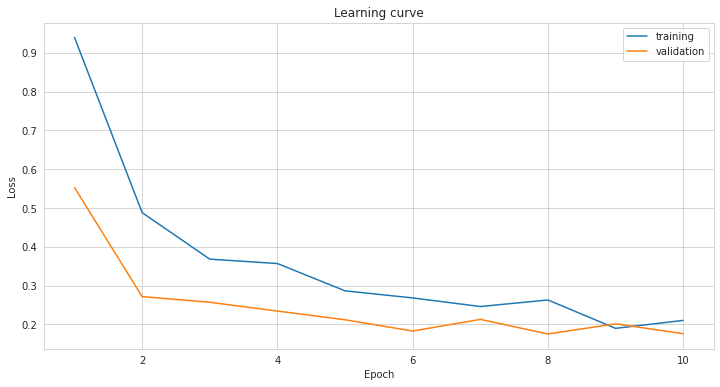

In [17]:
fig = plt.figure(figsize=(12, 6))

import seaborn as sns
sns.set_style('whitegrid')

plt.plot(range(1, df_results.shape[0]+1), df_results['train_loss'], label='training')
plt.plot(range(1, df_results.shape[0]+1), df_results['valid_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning curve')
plt.show();